# Packages

In [144]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
# estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# feature importance
import lime
from lime import lime_tabular

from my_functions import plot_correlations, correlated_variables

import joblib
import dill
from contextlib import contextmanager
from time import time
import gc

# Preprocessing

## Feature engineering

In [145]:
features_to_drop = [
    # application
    'NAME_TYPE_SUITE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION'
    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
    'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
    'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI',
    'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
    # bureau
    'DAYS_CREDIT_UPDATE',
    # credit_card_balance
    'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
    'CNT_DRAWINGS_POS_CURRENT',
    # previous_application
    'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
    'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'CHANNEL_TYPE',
]

#features_to_drop = []

path_data = '/Users/gabriel/Documents/gabriel/Documents/Formation OC Data Scientist\
/Projet 7 Implementez un modele de scoring/data/'

@contextmanager
def timer(title):
    t0 = time()
    yield
    print("{} - done in {:.0f}s".format(title, time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    #df = df.copy()  # pour ne pas altérer le df de base
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na=nan_as_category)
    new_columns = [col for col in df.columns if col not in original_columns]
    return df, new_columns

# Binary encoder
def bin_encoder(df):
    code = {'F':0,
            'M':1,
            'N':0,
            'Y':1}
    
    for col in df.select_dtypes('object').columns:
        df[col] = df[col].map(code)
        
    return df


## application

# preprocessing application_train.csv
def application(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv(path_data+'application_train.csv', nrows= num_rows)
    print("Train samples: {}".format(len(df)))

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # drop columns
    df = df[[col for col in df.columns if col not in features_to_drop]]
    
    # Categorical features with Binary encode (0 or 1; two categories)
    bin_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    df[bin_features] = bin_encoder(df[bin_features])
    
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df


## bureau & bureau_balance

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv(path_data+'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(path_data+'bureau_balance.csv', nrows=num_rows)
    
    # drop columns
    bureau = bureau[[col for col in bureau.columns if col not in features_to_drop]]
    bb = bb[[col for col in bb.columns if col not in features_to_drop]]
    
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()  # pour libérer la mémoire allouée aux variables supprimées
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        #'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper()
                                    for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper()
                                   for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg


## previous_applications

# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv(path_data+'previous_application.csv', nrows=num_rows)
    
    # drop columns
    prev = prev[[col for col in prev.columns if col not in features_to_drop]]
    
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    # Days 365.243 values -> nan
    cols = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
            'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    for col in cols:
        prev[col].replace(365243, np.nan, inplace=True)
        
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        #'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        #'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper()
                                 for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper()
                                     for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper()
                                    for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg


## POS_CASH_balance

# preprocessing POS_CASH_balance.csv
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv(path_data+'POS_CASH_balance.csv', nrows=num_rows)
    
    # drop columns
    pos = pos[[col for col in pos.columns if col not in features_to_drop]]
    
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    
    return pos_agg


## installments_payments

# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv(path_data+'installments_payments.csv', nrows=num_rows)
    
    # drop columns
    ins = ins[[col for col in ins.columns if col not in features_to_drop]]
    
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = -ins['DPD']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
        
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    
    return ins_agg


## credit_card_balance

# preprocessing credit_card_balance.csv
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv(path_data+'credit_card_balance.csv', nrows=num_rows)
    
    # drop columns
    cc = cc[[col for col in cc.columns if col not in features_to_drop]]
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    
    return cc_agg


## Main

def data_preparation(debug=False):
    num_rows = 10_000 if debug else None
    df = application(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    df.set_index('SK_ID_CURR', inplace=True)
    
    return df

In [146]:
df = data_preparation(debug=False)

Train samples: 307511
Bureau df shape: (305811, 113)
Process bureau and bureau_balance - done in 21s
Previous applications df shape: (338857, 196)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 25s
Credit card balance df shape: (103558, 121)
Process credit card balance - done in 14s


In [4]:
df.shape

(307507, 588)

In [5]:
# Elimination des constantes

cst = df.nunique()
cst = cst[cst == 1]

df = df[[col for col in df.columns if col not in cst.index]]
df.shape

(307507, 561)

In [6]:
df.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,1,0,1,0,202500.0,406597.5,24700.5,351000.0,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,-19005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Séparation X et y

In [7]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (307507, 560)
y shape: (307507,)


## NaN

### Observations

In [8]:
X.isna().sum().sum()

45859143

In [9]:
X = X.replace([np.inf, -np.inf], np.nan)
X.isna().sum().sum()

45859163

In [10]:
X.dropna().shape

(73, 560)

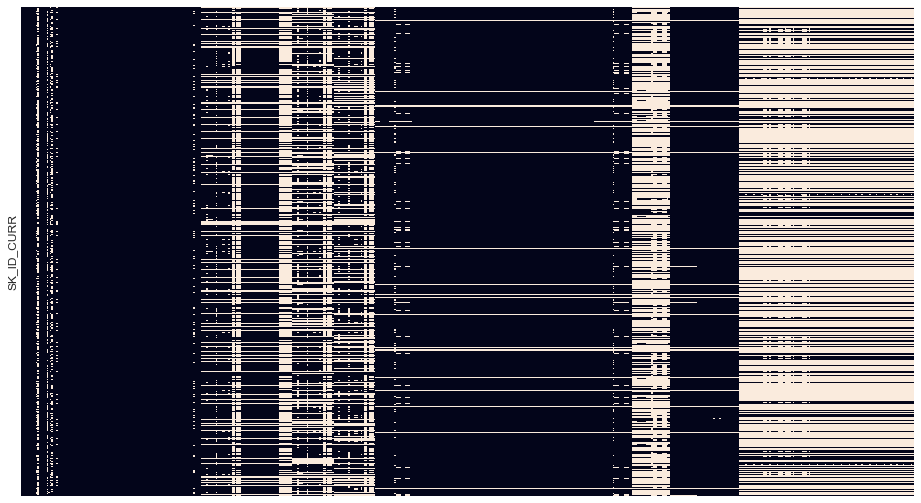

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(X.isna(), cbar=False, xticklabels='', yticklabels='')
plt.show()

### Suppression de colonnes

In [12]:
# On supprime les colonnes contenant plus de 60% de valeurs manquantes
nans = X.isna().mean().sort_values(ascending=False)
cols_to_drop = nans[nans>0.6].index

In [13]:
len(cols_to_drop)

159

In [14]:
X = X[[col for col in X.columns if col not in cols_to_drop]]
X.shape

(307507, 401)

## Corrélations

__On va supprimer les variables corrélées à d'autres à plus de 90%__

In [15]:
#X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)

In [16]:
threshold = 0.9
corr_variables = correlated_variables(X, min_corr=threshold)

In [17]:
len(corr_variables)

113

In [18]:
# Matrice des corrrélations en ne gardant que les variables corrélées
corr = X[corr_variables].corr()
# On masque la partie supérieure du triangle
mask = pd.DataFrame(np.triu(np.ones_like(corr, dtype=bool)), columns=corr.columns, index=corr.index)
corr = corr[~mask]

keep_features = []
skip_features = []
for col in corr_variables:
    if col in skip_features:
        continue
    keep_features.append(col)
    
    mask = (corr[col].abs() > threshold)
    skip_features = skip_features + list(corr.loc[mask, col].index)

In [19]:
len(keep_features)

53

In [20]:
X.shape

(307507, 401)

In [21]:
X = X[[col for col in X.columns if col not in skip_features]]
X.shape

(307507, 341)

## Variance

__On va supprimer les variables ayant une variance trop faible__

In [22]:
X.std().describe()

count    3.410000e+02
mean     1.032878e+07
std      1.892227e+08
min      1.627866e-05
25%      3.763904e-02
50%      1.658606e-01
75%      2.582561e+01
max      3.494295e+09
dtype: float64

In [23]:
X_ = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns, index=X.index)
std = X_.std()
std.describe()

count    341.000000
mean       0.092814
std        0.107563
min        0.001854
25%        0.012622
50%        0.044910
75%        0.133503
max        0.499735
dtype: float64

In [24]:
cols_to_drop = std[std<0.02].index
cols_to_drop.size

109

In [25]:
X.shape

(307507, 341)

In [26]:
X = X[[col for col in X.columns if col not in cols_to_drop]]
X.shape

(307507, 232)

## Sauvegarde de X et y

In [27]:
X.drop(columns='PREV_NAME_PORTFOLIO_POS_MEAN', inplace=True)

In [28]:
path = '/Users/gabriel/Documents/gabriel/Documents/Formation OC Data Scientist\
/Projet 7 Implementez un modele de scoring/data/'
X.to_csv(path+'X.csv')
y.to_csv(path+'y.csv')

# Import des data

In [147]:
path = '/Users/gabriel/Documents/gabriel/Documents/Formation OC Data Scientist\
/Projet 7 Implementez un modele de scoring/data/'
X = pd.read_csv(path+'X.csv', index_col=0)
y = pd.read_csv(path+'y.csv', index_col=0)['TARGET']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (307507, 231)
y shape: (307507,)


In [148]:
y.value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

In [149]:
y.value_counts(normalize=True)

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

On remplace les nan par une valeur numérique car sinon cela cause des problèmes avec l'API. On va prendre une valeur très qui ne se trouve pas dans le jeu de données.

In [150]:
X.isna().sum().sum()

4588524

In [151]:
nan = 1.01010101
X.fillna(nan, inplace=True)

In [152]:
X.isna().sum().sum()

0

In [153]:
(X==nan).sum().sum()

4588524

# Train/Test split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('X_train shape :', X_train.shape, 'y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape, 'y_test shape :', y_test.shape)

X_train shape : (230630, 231) y_train shape : (230630,)
X_test shape : (76877, 231) y_test shape : (76877,)


In [155]:
y_train.value_counts(normalize=True)

0    0.919056
1    0.080944
Name: TARGET, dtype: float64

In [156]:
y_test.value_counts(normalize=True)

0    0.919911
1    0.080089
Name: TARGET, dtype: float64

# Modélisation

## Preprocessing

## Modélisation

## Recherche des hyper-paramètres

## Enregistrement du modèle

In [157]:
pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean', missing_values=nan)),
                           ('scaler', StandardScaler()),
                           ('undersampler', RandomUnderSampler(random_state=0)),
                           ('model', LogisticRegression(random_state=42, max_iter=1000))
                          ])

In [158]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(missing_values=1.01010101)),
                ('scaler', StandardScaler()),
                ('undersampler', RandomUnderSampler(random_state=0)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [159]:
y_pred = pipeline.predict(X_train)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    211962
           1       0.17      0.69      0.27     18668

    accuracy                           0.70    230630
   macro avg       0.57      0.70      0.54    230630
weighted avg       0.90      0.70      0.77    230630



In [160]:
y_pred = pipeline.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     70720
           1       0.17      0.69      0.27      6157

    accuracy                           0.70     76877
   macro avg       0.56      0.69      0.54     76877
weighted avg       0.90      0.70      0.76     76877



In [161]:
pipeline

Pipeline(steps=[('imputer', SimpleImputer(missing_values=1.01010101)),
                ('scaler', StandardScaler()),
                ('undersampler', RandomUnderSampler(random_state=0)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [162]:
joblib.dump(pipeline, 'pipeline_projet7.joblib')

['pipeline_projet7.joblib']

# Feature importance

## Importance globale

In [163]:
model = pipeline['model']
model

LogisticRegression(max_iter=1000, random_state=42)

In [172]:
coefs = pd.Series(model.coef_[0], index=X.columns)
coefs

CODE_GENDER                       0.174868
FLAG_OWN_CAR                     -0.107452
FLAG_OWN_REALTY                   0.030187
CNT_CHILDREN                      0.028739
AMT_CREDIT                       -0.239697
                                    ...   
INSTAL_AMT_INSTALMENT_MAX         0.022591
INSTAL_AMT_PAYMENT_SUM            0.063599
INSTAL_DAYS_ENTRY_PAYMENT_MAX    -0.159154
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.155103
INSTAL_DAYS_ENTRY_PAYMENT_SUM    -0.003692
Length: 231, dtype: float64

In [176]:
best_coefs_abs = coefs.abs().sort_values(ascending=False)[:15]
coefs[best_coefs_abs.index]

EXT_SOURCE_2                    -0.391786
EXT_SOURCE_3                    -0.380888
BURO_CNT_CREDIT_PROLONG_SUM     -0.254899
APPROVED_AMT_ANNUITY_MEAN       -0.254256
POS_COUNT                       -0.244673
AMT_CREDIT                      -0.239697
AMT_ANNUITY                      0.230941
ACTIVE_CNT_CREDIT_PROLONG_SUM    0.205385
ACTIVE_DAYS_CREDIT_MEAN          0.182264
PREV_CNT_PAYMENT_MEAN            0.179695
ACTIVE_DAYS_CREDIT_MIN          -0.178319
EXT_SOURCE_1                    -0.175321
CODE_GENDER                      0.174868
APPROVED_AMT_CREDIT_MEAN         0.165786
PAYMENT_RATE                    -0.165247
dtype: float64

In [177]:
best_features = coefs[best_coefs_abs.index].index
best_values = - coefs[best_coefs_abs.index].values  # opposé pour plus de lisibilité

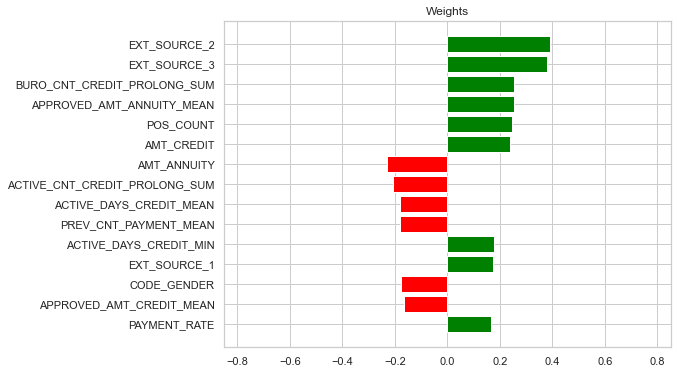

In [178]:
fig = plt.figure(figsize=(8,6))
plt.barh(best_features[::-1], best_values[::-1],
         color=["red" if coef<0 else "green" for coef in best_values[::-1]])
#plt.xticks(rotation=30, horizontalalignment='right')
plt.xlim(-0.85, 0.85)
plt.title("Weights");

## Importance locale

In [180]:
target_names = {0: 'Solvable', 1: 'Insolvable'}

In [181]:
preprocessing = pipeline[:2]
X_train_prep = preprocessing.transform(X_train)
X_test_prep = preprocessing.transform(X_test)

resampler = pipeline['undersampler']
X_train_res, y_train_res = resampler.fit_resample(X_train_prep, y_train)

y_train_res.value_counts()

0    18668
1    18668
Name: TARGET, dtype: int64

In [182]:
model = pipeline['model']

In [183]:
y_pred = model.predict(X_train_prep)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    211962
           1       0.17      0.69      0.27     18668

    accuracy                           0.70    230630
   macro avg       0.57      0.70      0.54    230630
weighted avg       0.90      0.70      0.77    230630



In [184]:
y_pred = model.predict(X_test_prep)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     70720
           1       0.17      0.69      0.27      6157

    accuracy                           0.70     76877
   macro avg       0.56      0.69      0.54     76877
weighted avg       0.90      0.70      0.76     76877



In [185]:
explainer = lime_tabular.LimeTabularExplainer(X_train_res, mode="classification",
                                              class_names=target_names,
                                              feature_names=X_train.columns,
                                             )

In [186]:
np.random.seed(0)
idx = np.random.randint(1, len(X_test_prep))

print("Prediction : ", target_names[pipeline['model'].predict(X_test_prep[idx].reshape(1,-1))[0]])
print("Actual :     ", target_names[y_test.values[idx]])

explanation = explainer.explain_instance(X_test_prep[idx], model.predict_proba,
                                         num_features=X.shape[1])

#explanation.show_in_notebook()

Prediction :  Solvable
Actual :      Solvable


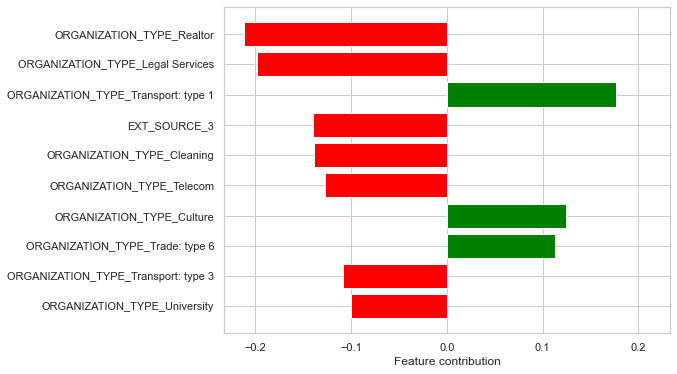

In [187]:
explanation_map = explanation.as_map()[1][:10]

feat_names = X_train.columns[[x[0] for x in explanation_map]]
feat_vals = [x[1] for x in explanation_map]
# On prend l'opposée des valeurs pour que ça soit plus lisible
#feat_vals = - np.array(feat_vals)

fig = plt.figure(figsize=(8,6))
plt.barh(feat_names[::-1], feat_vals[::-1],
         color=["red" if coef<0 else "green" for coef in feat_vals[::-1]])
#plt.xticks(rotation=30, horizontalalignment='right')
x1 = - abs(1.1*feat_vals[0])
x2 = - x1
plt.xlim(x1, x2)
plt.xlabel('Feature contribution')
plt.show()

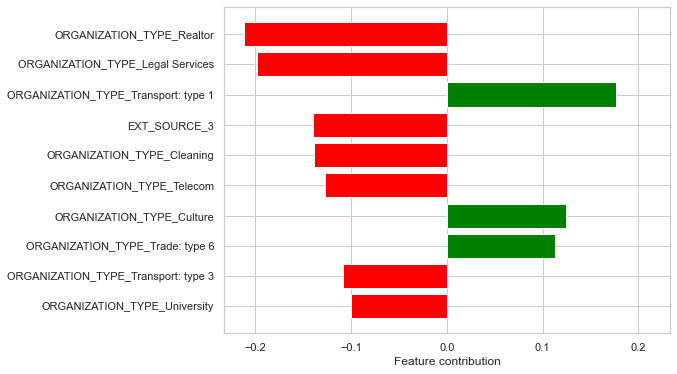

In [188]:
fig

In [189]:
# On sauvegarde l'explainer
with open('explainer.dill', 'wb') as f:
    dill.dump(explainer, f)

# Minimisation de la fonction coût-métier

## Precision-recall curve

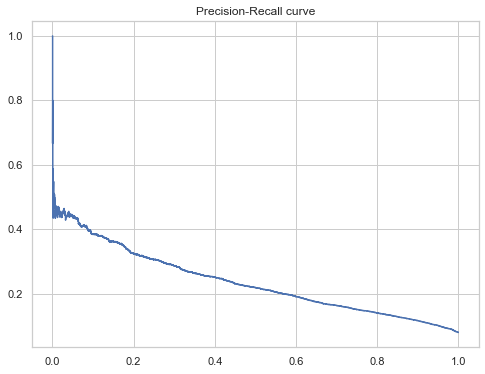

In [190]:
y_score = pipeline.predict_proba(X_test)[:,1]
#y_score = pipeline.decision_function(X_test)

precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(recall, precision)
ax.set_title('Precision-Recall curve')
plt.show()

In [191]:
mask = (threshold > 0.49999) & (threshold < 0.500005)
threshold[mask]

array([0.49999769])

In [192]:
print(precision[1:][mask])
print(recall[1:][mask])

[0.16557988]
[0.6928699]


## Définition et minimisation de la fonction coût

La fonction coût-métier à minimiser est de la forme $f = FP + 10FN$.
On peut montrer que 

\begin{equation}
\frac{1}{precision} + \frac{10}{recall} \propto FP + 10FN
\end{equation}

On va donc chercher à minimiser l'inverse de la précision plus l'inverse du recall en fonction du seuil.

In [193]:
loss = 1/precision[1:] + 10/recall[1:]

<ipython-input-193-6b3138b2e865>:1: RuntimeWarning: divide by zero encountered in true_divide
  loss = 1/precision[1:] + 10/recall[1:]


In [194]:
np.isinf(loss).sum()

1

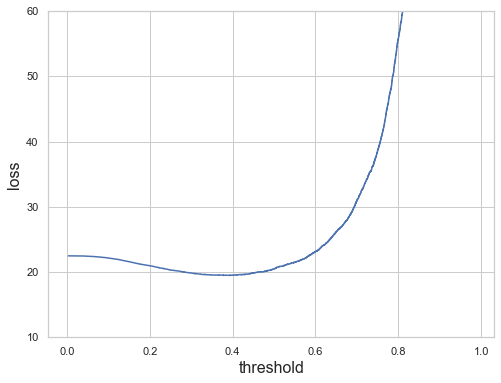

In [195]:
plt.figure(figsize=(8,6))
plt.plot(threshold, loss)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.ylim(10, 60)
plt.show()

In [196]:
loss.min()

19.484984399375975

In [197]:
mask = loss == loss.min()
loss[mask]

array([19.4849844])

In [198]:
# Seuil qui va minimiser la fonction coût
threshold_min = threshold[mask]
threshold_min

array([0.39232407])

In [199]:
# Probabilité au-delà de laquelle on va considérer le client solvable (classe 0)
proba_min = 1 - threshold_min
proba_min

array([0.60767593])

## Scores

In [200]:
precision[1:][mask]

array([0.13371926])

In [201]:
recall[1:][mask]

array([0.83287315])

In [202]:
probs = pipeline.predict_proba(X)
probs

array([[0.05434151, 0.94565849],
       [0.9324979 , 0.0675021 ],
       [0.80625761, 0.19374239],
       ...,
       [0.61063479, 0.38936521],
       [0.66080676, 0.33919324],
       [0.59324148, 0.40675852]])

In [223]:
y_pred = [0 if prob[0] > proba_min else 1 for prob in probs]

In [224]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.53      0.69    282682
           1       0.13      0.83      0.23     24825

    accuracy                           0.56    307507
   macro avg       0.55      0.68      0.46    307507
weighted avg       0.90      0.56      0.65    307507

